In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
from scipy.stats import norm
import torch
from itertools import chain
from torch.utils.data import TensorDataset, DataLoader

import lib.Metrics as Metrics
import lib.train_functions as train_functions
import lib.utils as utils

from lib.regional_data_builder import DataConstructor, convert_to_torch
from lib.models import Encoder_Back_GRU, Decoder, Fa, Fp, FaFp
from lib.VAE import VAE

# from lib.encoders import 
from torch import nn
from torchdiffeq import odeint
from torch.distributions import Categorical, Normal
from filelock import FileLock

torch.set_num_threads(1)

In [2]:
dtype = torch.float32

# data stuff
window_size = 28
gamma = 28
t = torch.arange(window_size + gamma + 1, dtype=dtype)/7

# training stuff
batch_size = 32
lr = 1e-3
n_samples = 64
eval_pts = np.arange(0,t.shape[-1], 7)
epochs = 250

# model training info
training_info =   {
    'UONN': {'nll':True, 'kl_z':True, 'kl_p':True,  'Fa_norm':True,  'reg_loss':True,  'anneal':True},
    'CONN': {'nll':True, 'kl_z':True, 'kl_p':True,  'Fa_norm':False, 'reg_loss':True,  'anneal':True},
    'SONN': {'nll':True, 'kl_z':True, 'kl_p':False, 'Fa_norm':False, 'reg_loss':False, 'anneal':True},
}

# model region info 
region_info = {
    'state': {
        'n_regions': 49,
        'latent_dim': 5,
        'n_qs':5,
        'ode_params':{'nhidden':32, 'aug_net_sizes':[64, 64]},
        'dec_params':{},
        'enc_params':{'q_sizes':[256, 128], 'ff_sizes':[128, 64], 'SIR_scaler':[0.1, 0.05, 1.0]}
    },
    'hhs': {
        'n_regions': 10,
        'latent_dim': 5,
        'n_qs':9,
        'ode_params':{'nhidden':32, 'aug_net_sizes':[64, 64]},
        'dec_params':{},
        'enc_params':{'q_sizes':[128, 64], 'ff_sizes':[64, 32], 'SIR_scaler':[0.1, 0.05, 1.0]}
    },
    'US': {
        'n_regions': 1,
        'latent_dim': 6,
        'n_qs':90,
        'ode_params':{'nhidden':32, 'aug_net_sizes':[64, 64]},
        'dec_params':{},
        'enc_params':{'q_sizes':[64, 32], 'ff_sizes':[32,16], 'SIR_scaler':[0.1, 0.05, 1.0]}
    }
}
ode_names = ['SONN', 'CONN', 'UONN']
test_seasons = [2015, 2016, 2017, 2018]
regions = ['US']
nums = [10,11,12]


started_file_path = "started.txt"

In [3]:
num = 1
region = 'US'
test_season = 2017
ode_name = 'UONN'
losses = training_info[ode_name]

print(region, ode_name, test_season, num)

ode = {'CONN':Fp, 'UONN':FaFp, 'SONN':Fa}[ode_name]

file_prefix = f'weights/{region}/pre_trained_{ode_name}/{test_season}_{num}_'
norm_prefix = f'norms/{region}/pre_trained_{ode_name}/{test_season}_{num}_'
chkpt_prefix = f'chkpts/{region}/pre_trained_{ode_name}/{test_season}_{num}_'
load_file_prefix = f'weights/{region}/{ode_name}/{test_season}_{num}_'

US UONN 2017 1


In [4]:
n_regions = 1
latent_dim = 16
n_qs = 90
ode_params = {'net_sizes':[20, 20], 'aug_net_sizes':[64, 64]},

ode_params = {
    'net_sizes': [20, 20],  # example values, adjust as needed
    'aug_net_sizes': [32, 32]  # example values, adjust as needed
}

dec_params = {}
enc_params = {'q_sizes':[64, 32], 'ff_sizes':[32,16], 'SIR_scaler':[0.1, 0.05, 1.0]}

In [5]:
_data = DataConstructor(test_season=test_season, region = region, window_size=window_size, n_queries=n_qs, gamma=gamma)
x_train, y_train, x_test, y_test, scaler = _data(run_backward=True, no_qs_in_output=True)
train_loader, x_test, y_test = convert_to_torch(x_train, y_train, x_test, y_test, batch_size=32, shuffle=True, dtype=dtype)

In [6]:
model = VAE(Encoder_Back_GRU, ode, Decoder, n_qs, latent_dim, n_regions, file_prefix=load_file_prefix, chkpt_prefix=chkpt_prefix, ode_params=ode_params, enc_params=enc_params, dec_params=dec_params)
model.setup_training(lr=lr)
model.file_prefix = file_prefix

In [7]:
model.pre_train(train_loader)

Training: 100%|██████████| 153/153 [00:02<00:00, 71.63it/s, Epoch=3, KL_z=0.00119]


In [9]:
eval_pts=[0,7,14]
time_steps = t[:(eval_pts[-1]+1)]
validate = {'x_test':x_test, 'y_test':y_test, 't':t, 'scaler':scaler, 'n_samples':128}

In [10]:
model.train(train_loader, time_steps, epochs, losses, eval_pts, n_samples = n_samples, grad_lim=1500, checkpoint=False, track_norms=True, norm_file=f'{norm_prefix}norms.txt', disable=False, validate = None)

Training 1:   0%|          | 0/153 [04:15<?, ?it/s]


NotImplementedError: Module [ModuleList] is missing the required "forward" function

(-3.0, 0.0)

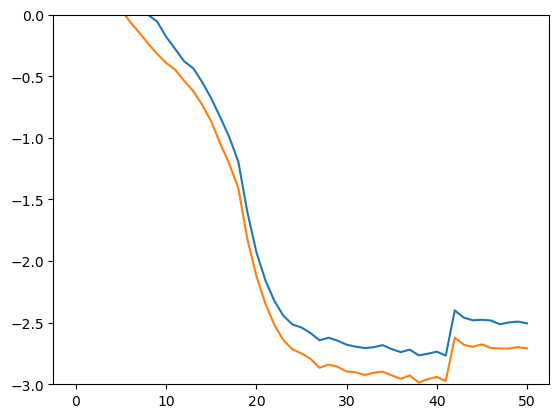

In [34]:
plt.plot([h['loss'] for h in model._history.epoch_history])
plt.plot([h['nll'] for h in model._history.epoch_history])
plt.ylim([-3,0])

In [35]:
x_te = torch.tensor(x_train[-365:], dtype=torch.float32)
y_te = torch.tensor(y_train[-365:], dtype=torch.float32)

y_pred = model(x_te, t, n_samples = 128, training=False)

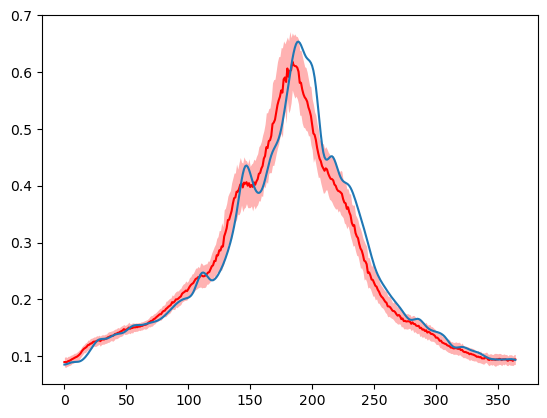

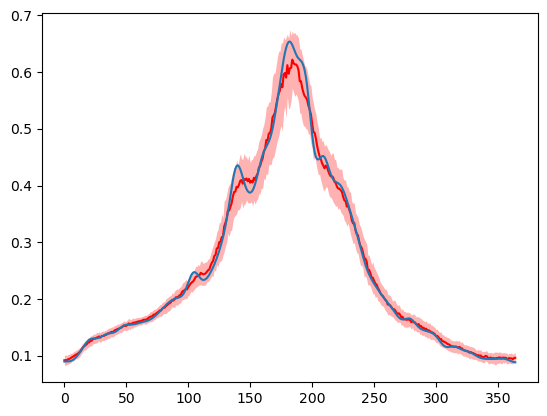

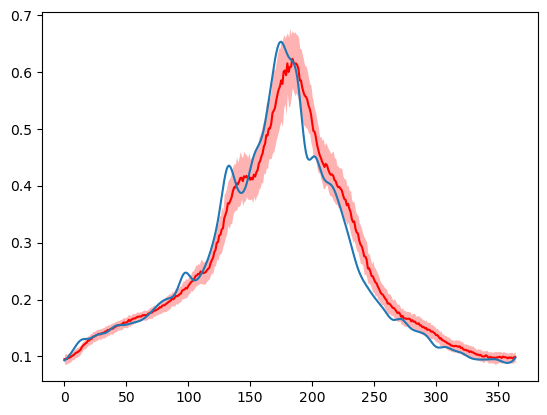

In [36]:
mean = y_pred.mean(1)
std = y_pred.std(1)

for g in eval_pts:
    plt.plot(mean[:, g, 0], color='red')
    plt.fill_between(np.arange(mean.shape[0]), (mean-std)[:, g, 0], (mean+std)[:, g, 0], color='red', linewidth=0, alpha=0.3)

    plt.plot(y_te[:, g, 0])
    plt.show()